# PN2V Prediction
Please run the `2_ProbabilisticNoise2VoidTraining.ipynb` notebook first.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import torch
from tifffile import imread

from ppn2v.pn2v.utils import PSNR
from ppn2v.pn2v import utils
from ppn2v.pn2v import prediction
from ppn2v.pn2v import histNoiseModel
from ppn2v.pn2v import gaussianMixtureNoiseModel

# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

In [2]:
# We need the training data in order to calulate 'mean' and 'std' for normalization
path="../../../data/Mouse skull nuclei/Mouse skull nuclei/"

# Load the test data
dataTest=imread(path+"example2_digital_offset300.tif")[:,:,:256] 
# We are loading only a sub image to speed up computation

# We estimate the ground truth by averaging.
dataTestGT=np.mean(dataTest[:,...],axis=0)[np.newaxis,...]



### Load the correct `namePN2VModel` and `dataName`

In [3]:
dataName = 'mouseskullnuclei'# Use the same name as used in 2_ProbabilisticNoise2VoidTraining.ipynb. This is a part of model name created in ProbabilisticNoise2VoidTraining.ipynb
# Load the noiseModel of interest 
nameNoiseModel ='HistNoiseModel_'+dataName+'_'+'calibration'
#nameNoiseModel='GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'calibration'
#nameNoiseModel ='HistNoiseModel_'+dataName+'_'+'bootstrap'
#nameNoiseModel='GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'bootstrap'


In [4]:
namePN2VModel=nameNoiseModel
net=torch.load(path+"/last_"+namePN2VModel+".net")
if('HistNoiseModel' in namePN2VModel):
    histogram = np.load(path+nameNoiseModel+'.npy') 
    noiseModel= histNoiseModel.NoiseModel(histogram, device=device)
elif('GMMNoiseModel' in namePN2VModel):
    params= np.load(path+nameNoiseModel+'.npz')
    noiseModel = gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(params = params, device = device)    

### Evaluation

image: 0
PSNR input 28.02423798473431
PSNR prior 35.46437923733631
PSNR mse 36.06155696728841
-----------------------------------
image: 1
PSNR input 28.065531602490644
PSNR prior 35.535962951295744
PSNR mse 36.1688800977054
-----------------------------------
image: 2
PSNR input 28.035021421910734
PSNR prior 35.55598313682279
PSNR mse 36.18108278481049
-----------------------------------
image: 3
PSNR input 28.087744381628678
PSNR prior 35.58287546212378
PSNR mse 36.21896487922597
-----------------------------------
image: 4
PSNR input 28.061745249613562
PSNR prior 35.46719810111655
PSNR mse 36.08395294937257
-----------------------------------
image: 5
PSNR input 28.1086316653067
PSNR prior 35.58460340599392
PSNR mse 36.23356504511225
-----------------------------------
image: 6
PSNR input 28.11584919615069
PSNR prior 35.63019292956216
PSNR mse 36.27891832819132
-----------------------------------
image: 7
PSNR input 28.078571033189487
PSNR prior 35.553021954798794
PSNR mse 36.201961

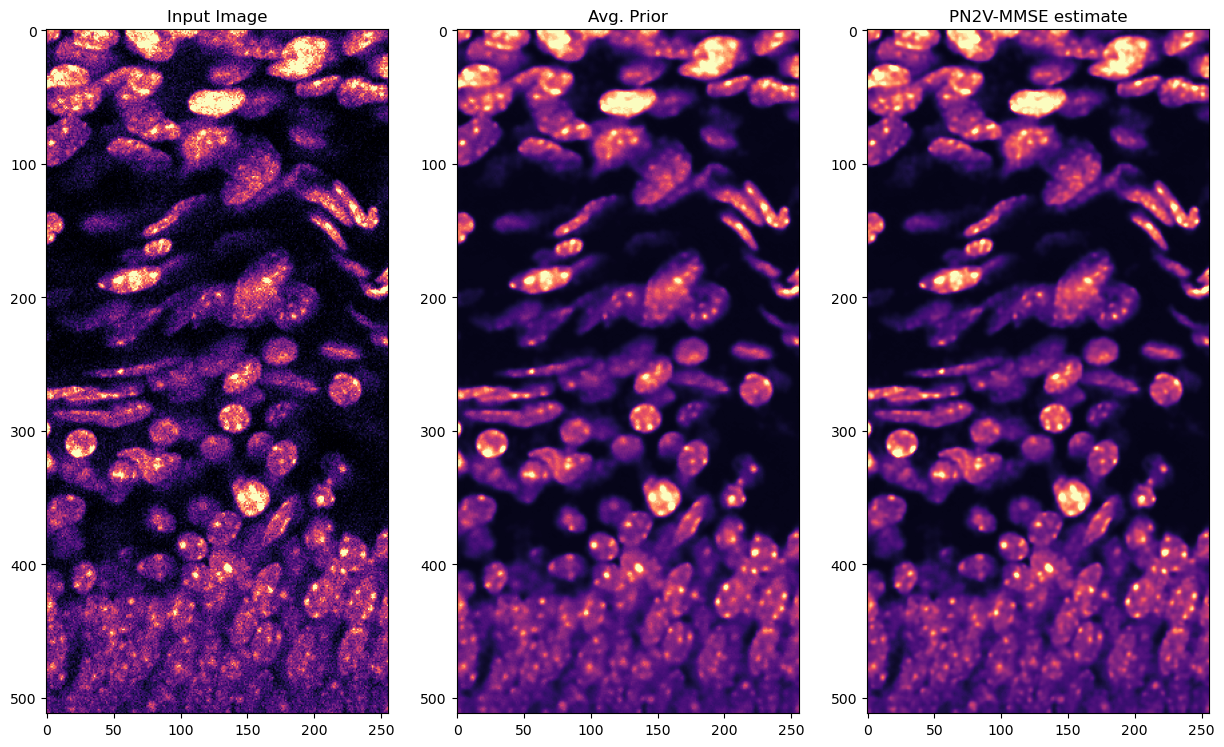

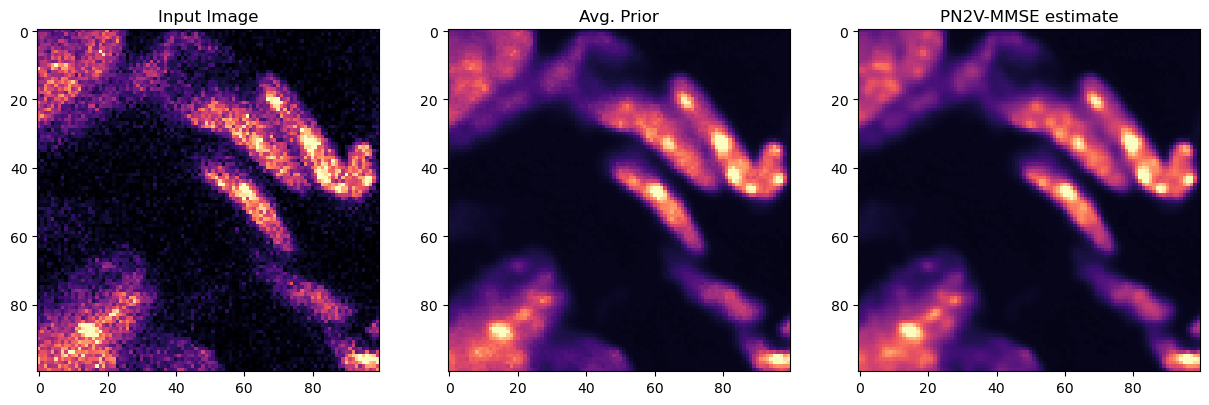

Avg PSNR Prior: 35.591344641420676 +-(2SEM) 0.008616470391203331
Avg PSNR MMSE: 36.24470985320028 +-(2SEM) 0.01020553855057037


In [5]:
# Now we are processing data and calculating PSNR values.
results=[]
meanRes=[]
resultImgs=[]
inputImgs=[]

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    
    im=dataTest[index]
    gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    means, mseEst = prediction.tiledPredict(im, net, ps=128, overlap=48,
                                             device=device, noiseModel=noiseModel)

    
    resultImgs.append(mseEst)
    inputImgs.append(im)

    rangePSNR=np.max(gt)-np.min(gt)
    psnr=PSNR(gt, mseEst,rangePSNR )
    psnrPrior=PSNR(gt, means,rangePSNR )
    results.append(psnr)
    meanRes.append(psnrPrior)

    print ("image:",index)
    print ("PSNR input",PSNR(gt, im, rangePSNR))
    print ("PSNR prior",psnrPrior) # Without info from masked pixel
    print ("PSNR mse",psnr) # MMSE estimate using the masked pixel
    print ('-----------------------------------')

    
    
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 3)
plt.title(label='PN2V-MMSE estimate')
plt.imshow(mseEst, vmax=vma, vmin=vmi, cmap='magma')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 3)
plt.title(label='PN2V-MMSE estimate')
plt.imshow(mseEst[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
plt.show()

print("Avg PSNR Prior:", np.mean(np.array(meanRes) ), '+-(2SEM)',2*np.std(np.array(meanRes) )/np.sqrt(float(len(meanRes)) ) )
print("Avg PSNR MMSE:", np.mean(np.array(results) ),  '+-(2SEM)' ,2*np.std(np.array(results) )/np.sqrt(float(len(results)) ) )